<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum Computer Vision</h1>

<h2>Imports<h2>

In [1]:
from PIL import Image
import io
import os
import random
import requests
import numpy as np
import zipfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Activation, Dense, BatchNormalization,  Dropout
# from tensorflow.keras import optimizers
# from tensorflow.keras.metrics import categorical_crossentropy
# from tensorflow.keras.metrics import categorical_accuracy

**Gebruik een <i>environment variable</i> voor het instellen van het logleven van TensorFlow**

In [2]:
os.environ['TF_CPP_MIN_LEVEL'] = '2'

<h2>Data Collection</h2>

<h3>Data downloaden</h3>

In [3]:
dataUrl = requests.get("http://madm.dfki.de/files/sentinel/EuroSAT.zip")
dataFile = zipfile.ZipFile(io.BytesIO(dataUrl.content))

In [4]:
# get file names
txtFiles = list()

for txtFile in dataFile.namelist():
    txtFiles.append(txtFile)
    # print(txtFile)

<h3>Data filteren</h3>

In [5]:
txtFiles = [x for x in txtFiles if ".jpg" in x]

<h3>Data inlezen</h3>

In [6]:
imageObjects = np.zeros([len(txtFiles), 64, 64, 3])

i = 0

for pic in txtFiles:
  imageObjects[i] = np.asarray(Image.open(dataFile.open(pic))).astype('uint8')/255
  i += 1
    
# print(imageObjects[0])    

**Gebruik de bestandsnamen voor het verkrijgen van de labels**

In [7]:
imageLabels = np.empty(len(txtFiles), dtype = 'S20')

i = 0

for label in txtFiles:
    txtFiles[i] = label.split('/')[1]
    i += 1
    
# print(txtFiles[0])    

In [8]:
# change them to integers in alphabetical order
labelNames, labelNumbers = np.unique(txtFiles, return_inverse=True)
labelDict = dict(zip(np.unique(labelNumbers), labelNames))
print(labelNames)
# print(labelNumbers)

np.array(np.unique(labelNumbers, return_counts=True)).T

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

<h3>Data splitten</h3>

In [9]:
trainSet, testSet, trainLabels, testLabels = train_test_split(imageObjects, labelNumbers, stratify = labelNumbers, train_size = 0.75, random_state=42)
print(trainSet.shape)
nrOfImages = len(trainSet)

(20250, 64, 64, 3)


<h3>Data inspecteren</h3>

In [10]:
def inspectData():
    
    plt.figure(figsize=(10,10))
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        number = i
        plt.imshow(trainSet[number])
        plt.xlabel(labelNames[trainLabels[number]]) 
    
    plt.show()

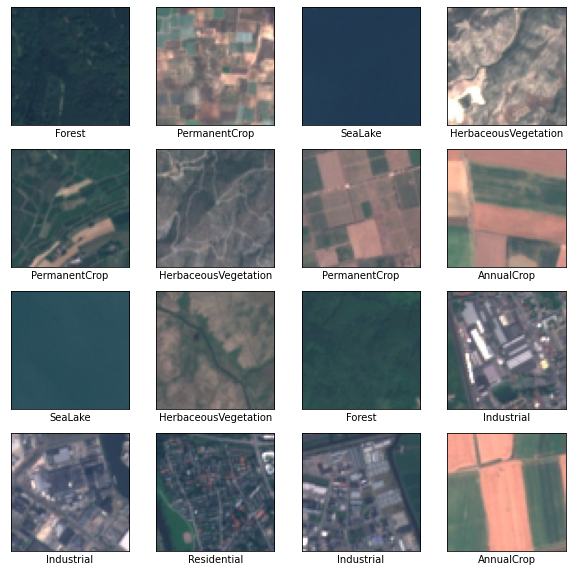

In [11]:
inspectData()    

<h2>Maak een model</h2>

<h3>Definieer de netwerktopologie</h3>

<h3>Exercise 1</h3>
<p>
    Vul de netwerktopologie tot een bruikbaar Neural Netwerk onstaat.
</p>

In [12]:
num_classes = len(labelNames)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

2022-10-21 10:23:45.709446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Definieer de trainparameters</h3>

In [13]:
lossFunction = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
gdAlgorithm = keras.optimizers.Adam(learning_rate=0.001)
nrOfEpochs = 5

<h3>Train het model</h3>

In [14]:
model.compile(optimizer=gdAlgorithm, loss=lossFunction, metrics="accuracy")
history = model.fit(trainSet, trainLabels, epochs=nrOfEpochs, batch_size=64, verbose=2)

Epoch 1/5
317/317 - 33s - loss: 1.2805 - accuracy: 0.5182 - 33s/epoch - 104ms/step
Epoch 2/5
317/317 - 30s - loss: 0.8391 - accuracy: 0.6982 - 30s/epoch - 96ms/step
Epoch 3/5
317/317 - 31s - loss: 0.7016 - accuracy: 0.7461 - 31s/epoch - 98ms/step
Epoch 4/5
317/317 - 32s - loss: 0.5908 - accuracy: 0.7906 - 32s/epoch - 102ms/step
Epoch 5/5
317/317 - 32s - loss: 0.5157 - accuracy: 0.8150 - 32s/epoch - 100ms/step


<h3>Test het model</h3>

<h3>Exercise 2</h3>
<p>
    Test het Neural Netwerk met de testset en laat zien of het in staat is de juiste class te vinden.
</p>

In [15]:
model.compile(optimizer=gdAlgorithm, loss=lossFunction, metrics="accuracy")
history_test = model.fit(testSet, testLabels, epochs=nrOfEpochs, batch_size=64, verbose=2)


Epoch 1/5
106/106 - 11s - loss: 0.5365 - accuracy: 0.8077 - 11s/epoch - 101ms/step
Epoch 2/5
106/106 - 10s - loss: 0.5027 - accuracy: 0.8204 - 10s/epoch - 98ms/step
Epoch 3/5
106/106 - 10s - loss: 0.4286 - accuracy: 0.8474 - 10s/epoch - 99ms/step
Epoch 4/5
106/106 - 11s - loss: 0.4294 - accuracy: 0.8467 - 11s/epoch - 101ms/step
Epoch 5/5
106/106 - 11s - loss: 0.3865 - accuracy: 0.8647 - 11s/epoch - 107ms/step


211/211 - 4s - loss: 0.3234 - accuracy: 0.8834 - 4s/epoch - 20ms/step


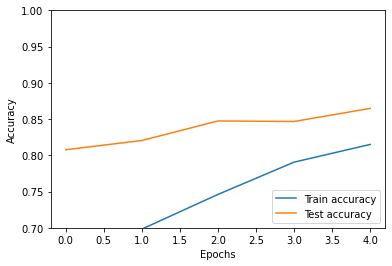

In [16]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history_test.history['accuracy'], label = 'Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testSet,  testLabels, verbose=2)

In [17]:
pred = model.predict(testSet, batch_size=16)

pred = np.argmax(pred, axis=-1)

print(pred)

# original labels

actual = np.argmax(testLabels,axis=-1)

# from sklearn.metrics import classification_report

# print(classification_report(labels, pred))

conf_matrix = tf.math.confusion_matrix(labels=testLabels, predictions=pred)

print(conf_matrix)

[9 9 0 ... 1 3 9]
tf.Tensor(
[[664   5  24   0   0  27  22   0   1   7]
 [  0 722  15   0   0  12   0   0   1   0]
 [  5   0 702   2   1   9  16  12   2   1]
 [ 18   1  57 443   6  26  36  14  24   0]
 [  0   0  20   1 595   0   1   8   0   0]
 [  1  13  26   0   0 454   5   0   1   0]
 [ 16   0 105   4   0  27 470   2   1   0]
 [  0   0   2   1   0   0   0 747   0   0]
 [ 15   9  15  27   0  54   3   0 501   1]
 [  1  68   9   0   0   5   0   0   2 665]], shape=(10, 10), dtype=int32)


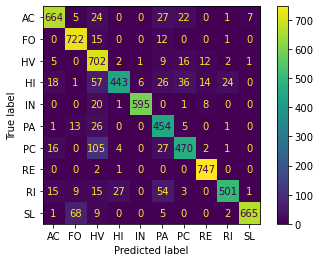

In [18]:

actual = testLabels
predicted = pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['AC', 'FO', 'HV', 'HI', 'IN', 'PA', 'PC', 'RE', 'RI', 'SL']
)

cm_display.plot()
plt.show()


In [19]:
#trunked labels for clarity: 
# AnnualCrop = AC
# Forest = FO 
# HerbaceousVegetation = HV
# Highway = HI
# Industrial = IN
# Pasture = PA
# PermanentCrop = PC
# Residential = RE
# River = RI
# SeaLake = SL
